# IndoML 2023 Tuturial: Part 2
## At Sesame street

### Plan:

1. We will use Huggingface transformers for finetuning pretrained models.
2. This will allow us to easily swap out models to find the most suitable one.
    * This is achieved using the `AutoModel*` and `AutoTokenizer` classes.
3. It also comes with various new libraries integrated for efficient fine-tuning, 
multi-gpu or distributed training, and more.

### Models that you can try with this script

1. DistilBERT
2. bert-base-multilingual-cased
3. XLM-RoBERTa
etc.

### Efficient Training

Full finetuning can be often slow and expensive. So, some alternative methods for efficient training are:

1. Linear Probing
2. PEFT + Low-Rank Adaptation
3. Distilled Models
4. **Use models finetuned on MASSIVE as your starting point.** You can search for such models on Huggingface  ([List1](https://huggingface.co/models?dataset=dataset:AmazonScience%2Fmassive&sort=downloads), [List2](https://huggingface.co/models?sort=downloads&search=massive-intent))

### Libraries explored

1. 🤗 Transfomers > Trainer
2. 🤗 Evaluate
2. wandb

In [1]:
%env CUDA_VISIBLE_DEVICES=4

env: CUDA_VISIBLE_DEVICES=4


## Load `dataset`

In [2]:
from tqdm import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

tqdm.pandas()

dataset = load_dataset("AmazonScience/massive")


/nlsasfs/home/ttbhashini/arroy/anaconda3/envs/py38-new/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load `AutoTokenizer`

In [3]:
checkpoint = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["utt"], truncation=True)



## Preprocessing

### Using the Trainer class

We will be using the HF Trainer class to handle a lot of the boilerplate tasks. This Trainer class expects certain format for the dataset.

1. Tokenize the dataset
2. A "labels" column should exits

In [4]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map: 100%|██████████| 151674/151674 [00:05<00:00, 27216.33 examples/s]


In [5]:
tokenized_datasets['train'][0].keys()

dict_keys(['id', 'locale', 'partition', 'scenario', 'intent', 'utt', 'annot_utt', 'worker_id', 'slot_method', 'judgments', 'input_ids', 'token_type_ids', 'attention_mask'])

In [6]:
# Remove columns that are not needed
to_remove = list(tokenized_datasets['train'][0].keys())

# Don't remove these columns
to_remove.remove('input_ids')
to_remove.remove('attention_mask')
to_remove.remove('intent')

# tokenized_datasets = tokenized_datasets.remove_columns(to_remove)
tokenized_datasets = tokenized_datasets.rename_column('intent', 'labels')


In [7]:
tokenized_datasets['train'].features

{'id': Value(dtype='string', id=None),
 'locale': Value(dtype='string', id=None),
 'partition': Value(dtype='string', id=None),
 'scenario': ClassLabel(names=['social', 'transport', 'calendar', 'play', 'news', 'datetime', 'recommendation', 'email', 'iot', 'general', 'audio', 'lists', 'qa', 'cooking', 'takeaway', 'music', 'alarm', 'weather'], id=None),
 'labels': ClassLabel(names=['datetime_query', 'iot_hue_lightchange', 'transport_ticket', 'takeaway_query', 'qa_stock', 'general_greet', 'recommendation_events', 'music_dislikeness', 'iot_wemo_off', 'cooking_recipe', 'qa_currency', 'transport_traffic', 'general_quirky', 'weather_query', 'audio_volume_up', 'email_addcontact', 'takeaway_order', 'email_querycontact', 'iot_hue_lightup', 'recommendation_locations', 'play_audiobook', 'lists_createoradd', 'news_query', 'alarm_query', 'iot_wemo_on', 'general_joke', 'qa_definition', 'social_query', 'music_settings', 'audio_volume_other', 'calendar_remove', 'iot_hue_lightdim', 'calendar_query', 'em

## Dataloaders [Optional]

- Instead of going through individual samples in the dataset, we would like to 
batches of samples to train our model. 
- Dataloader
    1. Creates an "iterator" over the dataset, which returns a batch of samples every turn
    2. Handles shuffling
    3. Collates samples into batches, by padding the input sequences to the maximum length in the batch

In [8]:
# from torch.utils.data import DataLoader

# train_dataloader = DataLoader(
#     tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=data_collator
# )
# eval_dataloader = DataLoader(
#     tokenized_datasets["validation"], batch_size=8, collate_fn=data_collator
# )

In [9]:
# Check the shape of the tensors
# for batch in tqdm(train_dataloader):
#     break
# {k: v.shape for k, v in batch.items()}

```python
{'labels': torch.Size([8]),
 'input_ids': torch.Size([8, 25]),
 'attention_mask': torch.Size([8, 25])}
```

## Load model using an `AutoModel`

In [10]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=tokenized_datasets['train'].features['labels'].num_classes)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
# # Let's check the output of a single forward pass
# outputs = model(**batch)
# print(outputs.loss, outputs.logits.shape)

## Setup Evaluation Metric

In [13]:
import numpy as np
import evaluate

metric_acc = evaluate.load("accuracy")
metric_f1 = evaluate.load("f1")

# We need to define a compute_metric function that is supported by the Trainer output
# It basically converts the logits to predictions and then calls the metric
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # print("Predictions: ", predictions)
    # print("Labels: ", labels)
    return metric_f1.compute(predictions=predictions, references=labels, average="macro")

## Tweak the data distribution!

- We are changing the training set distribution.
- But keeping the validation set distribution the same.

In [14]:
# All the langauges in the dataset
# ['mn-MN', 'af-ZA', 'el-GR', 'ta-IN', 'ar-SA', 'ur-PK', 'pl-PL',
#        'ko-KR', 'az-AZ', 'da-DK', 'kn-IN', 'tl-PH', 'is-IS', 'lv-LV',
#        'it-IT', 'es-ES', 'fr-FR', 'ml-IN', 'km-KH', 'fa-IR', 'sw-KE',
#        'en-US', 'tr-TR', 'bn-BD', 'he-IL', 'te-IN', 'pt-PT', 'ka-GE',
#        'ja-JP', 'id-ID', 'ru-RU', 'hy-AM', 'nb-NO', 'ms-MY', 'sq-AL',
#        'sv-SE', 'fi-FI', 'th-TH', 'de-DE', 'vi-VN', 'my-MM', 'jv-ID',
#        'sl-SL', 'hi-IN', 'nl-NL', 'zh-CN', 'hu-HU', 'ro-RO', 'zh-TW',
#        'cy-GB', 'am-ET']

# Create dataframe of id and locale
df_train = dataset['train'].to_pandas()
df_eval = dataset['validation'].to_pandas()

selected_languages = ["en-US", "de-DE", "bn-BD", "hi-IN"]

df_train = df_train[df_train['locale'].isin(selected_languages)]
# df_eval = df_eval[df_eval['locale'].isin(selected_languages)] 



In [15]:
import random
# Select random samples from above subsets
n_train = 40960
n_eval = 2096
train_indices = random.sample(df_train.index.tolist(), n_train)
eval_indices = random.sample(range(len(tokenized_datasets['validation'])), n_eval)

In [16]:
train_data_subset = tokenized_datasets["train"].select(train_indices)
eval_data_subset = tokenized_datasets["validation"].select(eval_indices)

## Setup Trainer and Finetuning

1. When testing your code for the first time, it is a better idea to use a smaller dataset,
so that you can quickly iterate over your code.
2. We have done the same here by using 128 + 32 samples from the dataset, for training and validation respectively.

In [20]:
from transformers import TrainingArguments

eval_steps = 1000

training_args = TrainingArguments(
    output_dir="./results/stage1/",
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    fp16=True,
    # warmup_steps=500,
    # weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=eval_steps,
    eval_steps=eval_steps,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none" # set "wandb" here to log to wandb
)

**Wandb Logging**

When training ML models, keeping track of various hyperparameters, the training and validation losses, and evaluation metrics is very important.
`wandb` can help you here.

To install wandb, run following commands in your terminal:

```bash
pip install wandb
# Then login to your wandb account
wandb login
```

Once, that is done, in TrainingArguments, set the `report_to` argument to `wandb`.

In [21]:
from transformers import Trainer

trainer = Trainer(
    model,
    training_args,
    # train_dataset=tokenized_datasets["train"],
    # eval_dataset=tokenized_datasets["validation"],
    train_dataset=train_data_subset, # Using the smaller subsets
    eval_dataset=eval_data_subset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [22]:
stats = trainer.train()

Step,Training Loss,Validation Loss,F1
1000,0.560800,2.389601,0.404910
2000,0.377600,2.343635,0.401373


In [23]:
# Print Stats
# trainer.compute_metrics = compute_metrics
from pprint import pprint
pprint(trainer.evaluate())

{'epoch': 2.0,
 'eval_f1': 0.40490950899244466,
 'eval_loss': 2.3896007537841797,
 'eval_runtime': 22.1973,
 'eval_samples_per_second': 94.426,
 'eval_steps_per_second': 2.973}


## Back to the full evaluation set

Now we will test the model on full evaluation set.

In [24]:
# Extract predictions on validation set
eval_data_subset = tokenized_datasets["validation"]
preds = trainer.predict(eval_data_subset)

In [25]:
# Create a dataframe with the predictions, targets and locale
import pandas as pd
df = pd.DataFrame({
    "id": eval_data_subset['id'],
    "predictions": preds.predictions.argmax(-1),
    "targets": preds.label_ids,
    "locale": eval_data_subset['locale']
})



In [26]:
# Compute f1 for each locale and plot f1 scores vs locales
from sklearn.metrics import f1_score, accuracy_score
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 8)}) # Setting some matplotlib configs



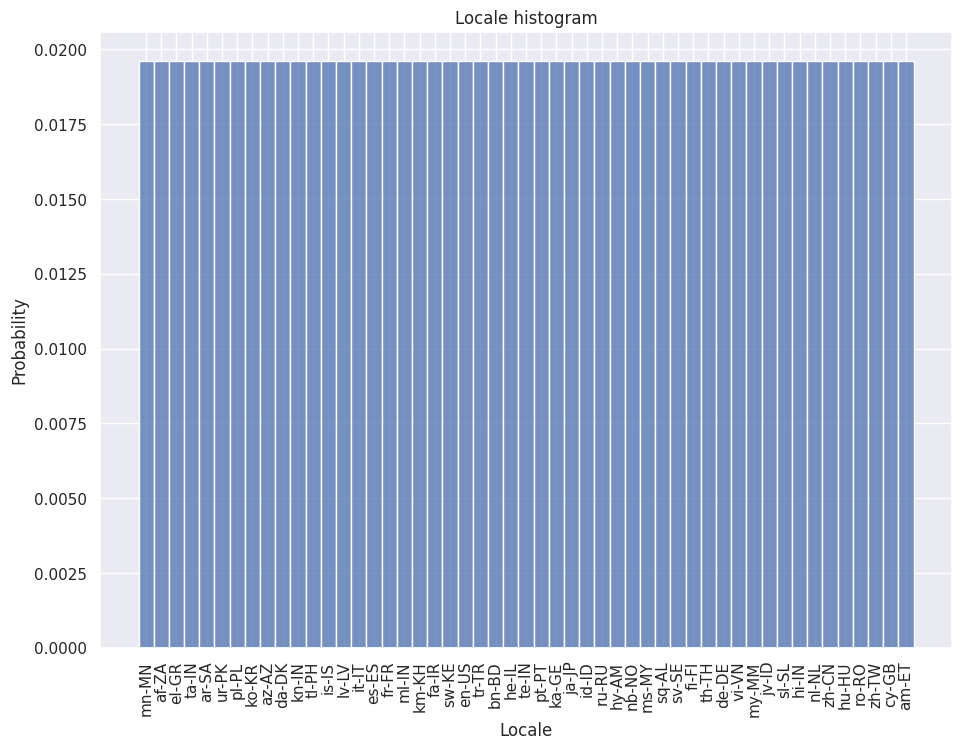

In [27]:
# Print histogram of locale, y-axis normalized to 1
P = sns.histplot(df['locale'], stat="probability")

P.set_xlabel("Locale")
P.set_ylabel("Probability")
P.set_title("Locale histogram")

# Rotate x labels by 90 degrees
for item in P.get_xticklabels():
    item.set_rotation(90)



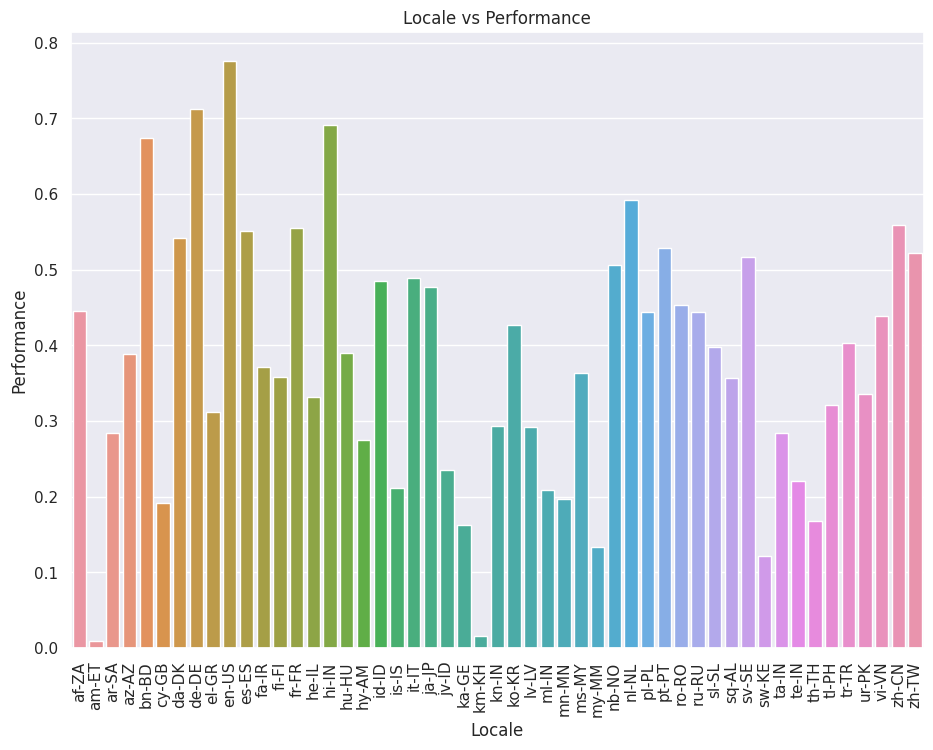

In [28]:
def compute_f1(df):
    return f1_score(df['targets'], df['predictions'], average='macro')

def compute_acc(df):
    return accuracy_score(df['targets'], df['predictions'])

df_f1 = df.groupby('locale').apply(compute_f1)
P = sns.barplot(x=df_f1.index, y=df_f1.values)
# df_acc = df.groupby('locale').apply(compute_acc)
# P = sns.barplot(x=df_acc.index, y=df_acc.values)

P.set_title("Locale vs Performance")
P.set_xlabel("Locale")
P.set_ylabel("Performance")

# Rotate x labels by 90 degrees
for item in P.get_xticklabels():
    item.set_rotation(90)



In [ ]:
# Full macro f1 score
compute_f1(df)